<a href="https://colab.research.google.com/github/ChoBazzi/ktb_AI/blob/main/ktb_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 75.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
# ===============================================
# 1. 라이브러리 불러오기
# ===============================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive 마운트 완료.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 마운트 완료.


In [ ]:
# 1. Google Drive 내 저장 경로 설정
DATA_PATH = '/content/drive/MyDrive/datasets/TensorFlow_Food101'

'''
# 2. 전역 변수 설정
IMG_SIZE = 224  # ResNet 기본 입력 크기
BATCH_SIZE = 32
BUFFER_SIZE = 1000 # 셔플을 위한 버퍼 크기
'''
print(f"데이터 저장 경로: '{DATA_PATH}'")

# 이미지 크기 및 배치 설정
IMG_SIZE = 224
BATCH_SIZE = 32 # 사용하는 GPU 메모리에 따라 조절
AUTOTUNE = tf.data.AUTOTUNE # tf.data 파이프라인 성능 최적화

# 1. 훈련(Train) 데이터용 데이터 증강(Augmentation) 레이어
# Keras 레이어로 정의하면 GPU에서 병렬 처리되어 효율적입니다.
# 'experimental'을 제외한 'preprocessing' 경로 사용
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.preprocessing.RandomResizedCrop(
        IMG_SIZE, IMG_SIZE, scale=(0.08, 1.0)
    ),
    tf.keras.layers.preprocessing.RandomFlip("horizontal"),
], name="data_augmentation")

# 2. ResNet 모델에 내장된 전용 전처리 함수
# 이 함수는 픽셀 값을 [0, 255]에서 ResNet이 학습된 방식(예: [-1, 1] 스케일)으로
# 정확하게 정규화(Normalization)합니다.
preprocess_fn = tf.keras.applications.resnet.preprocess_input

데이터 저장 경로: '/content/drive/MyDrive/datasets/TensorFlow_Food101'


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'preprocessing'

In [ ]:
import tensorflow_datasets as tfds
import os
from google.colab import drive

# 1️⃣ Google Drive 마운트
drive.mount('/content/drive')

# 2️⃣ 데이터셋 저장 경로 지정
DATA_PATH = '/content/drive/MyDrive/datasets/TensorFlow_Food101'

# 3️⃣ 빌더 생성 (버전 명시 가능)
builder = tfds.builder('food101', data_dir=DATA_PATH)

# 4️⃣ 이미 준비된 데이터가 있는지 폴더로 확인
version_folder = os.path.join(DATA_PATH, 'food101', builder.info.version.__str__())
if os.path.exists(version_folder):
    print(f"✅ 기존 데이터셋을 사용합니다: {version_folder}")
else:
    print("⚙️ 데이터셋이 없습니다. 다운로드 및 준비 중...")
    builder.download_and_prepare()

# 5️⃣ 데이터셋 불러오기
ds_train = builder.as_dataset(split='train', as_supervised=True)
ds_test   = builder.as_dataset(split='validation', as_supervised=True)
ds_info  = builder.info

# 6️⃣ 정보 출력
print("\n--- 데이터셋 정보 ---")
print(f"학습 데이터 수   : {ds_info.splits['train'].num_examples}")
print(f"검증(validation) 수: {ds_info.splits['validation'].num_examples}")
print(f"클래스 개수       : {ds_info.features['label'].num_classes}")
print("클래스 예시       :", ds_info.features['label'].names[:5])

class_names = ds_info.features['label'].names
print("\n클래스 예시:", class_names[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 기존 데이터셋을 사용합니다: /content/drive/MyDrive/datasets/TensorFlow_Food101/food101/2.0.0

--- 데이터셋 정보 ---
학습 데이터 수   : 75750
검증(validation) 수: 25250
클래스 개수       : 101
클래스 예시       : ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

클래스 예시: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']


In [ ]:

#전처리
def preprocess_train(image, label):
    """훈련 데이터셋 전처리 파이프라인"""
    # 원본 이미지는 uint8이므로 float32로 변환
    image = tf.cast(image, tf.float32)

    image = tf.image.resize(image, [244, 244])

    # 1. 데이터 증강 (Augmentation) 적용
    image = data_augmentation(image)

    # 2. ResNet 전용 정규화 (Normalization) 적용
    image = preprocess_fn(image)

    return image, label

def preprocess_val(image, label):
    """검증/테스트 데이터셋 전처리 파이프라인"""
    # 원본 이미지는 uint8이므로 float32로 변환
    image = tf.cast(image, tf.float32)

    # 1. 데이터 증강 없음 - 크기만 224x224로 조절
    # (PyTorch의 Resize(256) -> CenterCrop(224)와 달리,
    # Keras/TF에선 보통 검증셋도 Resize(224, 224)를 많이 사용)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # 2. ResNet 전용 정규화 (Normalization) 적용
    image = preprocess_fn(image)

    return image, label

'''
def preprocess_train(image, label):
    image = tf.image.resize(image, [244, 244])
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float16)  # 메모리 절약!
    return image, label


def preprocess_test(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float16)
    return image, label

'''
'''
def preprocess_train(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # 간단! 확실!
    # (굳이 명시 안 해도 됨)
    return image, label

def preprocess_train(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # 간단! 확실!
    # (굳이 명시 안 해도 됨)
    return image, label
'''

'\ndef preprocess_train(image, label):\n    image = tf.image.resize(image, [224, 224])\n    image = tf.cast(image, tf.float32)\n    image = image / 255.0  # 간단! 확실!\n    # (굳이 명시 안 해도 됨)\n    return image, label\n    \ndef preprocess_train(image, label):\n    image = tf.image.resize(image, [224, 224])\n    image = tf.cast(image, tf.float32)\n    image = image / 255.0  # 간단! 확실!\n    # (굳이 명시 안 해도 됨)\n    return image, label\n'

In [ ]:
# TFDS 최적화 옵션
AUTOTUNE = tf.data.AUTOTUNE

# === 학습용 DataLoader ===
train_loader = ds_train.map(preprocess_train, num_parallel_calls=AUTOTUNE)
train_loader = train_loader.shuffle(BUFFER_SIZE)
train_loader = train_loader.batch(BATCH_SIZE)
train_loader = train_loader.prefetch(buffer_size=AUTOTUNE) # 학습 중 다음 배치를 미리 준비

# === 테스트용 DataLoader ===
test_loader = ds_test.map(preprocess_test, num_parallel_calls=AUTOTUNE)
test_loader = test_loader.batch(BATCH_SIZE)
test_loader = test_loader.prefetch(buffer_size=AUTOTUNE)

print("\n--- TensorFlow 데이터 파이프라인(DataLoader) 준비 완료 ---")
print("학습용:", train_loader)
print("테스트용:", test_loader)

NameError: in user code:

    File "/tmp/ipython-input-1149402365.py", line 10, in preprocess_train  *
        image = data_augmentation(image)

    NameError: name 'data_augmentation' is not defined


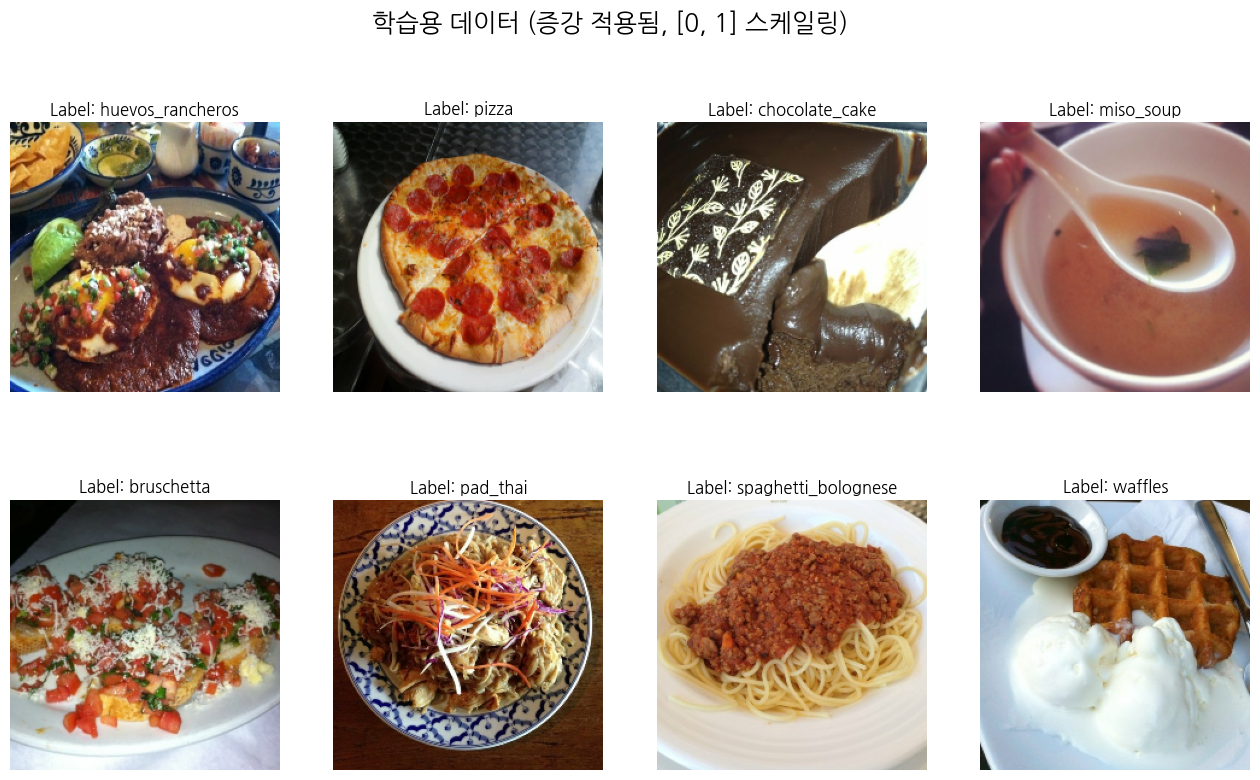

In [ ]:
# === 시각화용 전처리 함수 (ResNet 정규화 X, [0, 1] 스케일링 O) ===
def preprocess_vis(image, label):
    image = tf.image.resize(image, [IMG_SIZE + 20, IMG_SIZE + 20])
    image = tf.image.random_crop(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)

    # ResNet 정규화 대신 [0, 1] 스케일링
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

# 시각화용 로더 (1개 배치만 가져옴)
vis_loader = ds_train.map(preprocess_vis, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).take(1)



# 배치 1개 가져오기
for images, labels in vis_loader:
    plt.figure(figsize=(16, 9))
    plt.suptitle("학습용 데이터 (증강 적용됨, [0, 1] 스케일링)", fontsize=18)

    for i in range(8):
        if i >= len(images): break

        ax = plt.subplot(2, 4, i + 1)

        # TensorFlow 텐서를 NumPy 배열로 변환
        img = images[i].numpy()

        # 클래스 이름
        label_name = class_names[labels[i]]

        plt.imshow(img) # [0, 1] 범위이므로 올바르게 보임
        plt.title(f"Label: {label_name}")
        plt.axis("off")

    plt.show()
    break # 1개 배치만 확인

In [ ]:
# ===============================================
# 3. 사전 학습된 ResNet 불러오기 (Pretrained on ImageNet)
# ===============================================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False   # Feature extractor로만 사용 (학습 안 함)


num_classes = ds_info.features['label'].num_classes
# 새로운 분류기 헤드 추가
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print("\n▶ Fine-tuning 전 (사전 학습 모델 그대로) 평가 중...")
pretrained_eval = model.evaluate(test_loader, verbose=1)


▶ Fine-tuning 전 (사전 학습 모델 그대로) 평가 중...
790/790 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.0092 - loss: 5.0677


In [ ]:
print("\n======================")
print("ResNet50 성능 비교표")
print("======================")
print(f"사전 학습 모델 (학습 전) 정확도: {pretrained_eval[1]*100:.2f}%")


ResNet50 성능 비교표
사전 학습 모델 (학습 전) 정확도: 0.91%


과적합 조기종료 코드

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. 조기 종료 (EarlyStopping) 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 데이터의 손실(loss)
    patience=3,          # 3 에포크(epoch) 동안 성능이 개선되지 않으면 훈련 중단
    verbose=1            # 중단되었을 때 메시지를 출력
)

# 2. 최적 모델 저장 (ModelCheckpoint) 설정
#    조기 종료로 멈추더라도, 멈추기 직전의 모델이 아닌 '가장 좋았던' 모델을 저장해야 합니다.
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # 저장할 파일 경로
    monitor='val_loss',        # 모니터링할 지표: 검증 데이터의 손실(loss)
    save_best_only=True,       # monitor 지표가 개선되었을 때만 모델을 저장
    verbose=1                  # 모델이 저장될 때 메시지를 출력
)

# 훈련 시 사용할 콜백들을 리스트로 묶기
callbacks_list = [early_stopping, model_checkpoint]

In [ ]:
# 모델 컴파일
# (학습률(Learning Rate)은 파인튜닝 시 약간 낮게 시작하는 것이 좋습니다)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 보고서용으로 Epochs 수를 10 정도로 설정 (Colab GPU로 수십 분 소요될 수 있음)
EPOCHS = 20

print("\n--- 모델 학습 시작 ---")

# train_loader와 test_loader를 사용하여 모델 학습
history = model.fit(
    train_loader,
    validation_data=test_loader,
    epochs=EPOCHS,
    callbacks=callbacks_list # 콜백 적용!
)


print("--- 모델 학습 완료 ---")


--- 모델 학습 시작 ---
Epoch 1/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2347 - loss: 3.3710
Epoch 1: val_loss improved from inf to 1.79901, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 97s 69ms/step - accuracy: 0.2348 - loss: 3.3705 - val_accuracy: 0.5589 - val_loss: 1.7990
Epoch 2/20
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4073 - loss: 2.3794
Epoch 2: val_loss improved from 1.79901 to 1.69227, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 55ms/step - accuracy: 0.4073 - loss: 2.3794 - val_accuracy: 0.5787 - val_loss: 1.6923
Epoch 3/20
1182/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4306 - loss: 2.2813
Epoch 3: val_loss improved from 1.69227 to 1.62487, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.4306 - loss: 2.2813 - val_accuracy: 0.5887 - val_loss: 1.6249
Epoch 4/20
1182/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4430 - loss: 2.2313
Epoch 4: val_loss improved from 1.62487 to 1.61963, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 55ms/step - accuracy: 0.4430 - loss: 2.2313 - val_accuracy: 0.5960 - val_loss: 1.6196
Epoch 5/20
1182/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4473 - loss: 2.2032
Epoch 5: val_loss improved from 1.61963 to 1.59393, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 55ms/step - accuracy: 0.4473 - loss: 2.2031 - val_accuracy: 0.6017 - val_loss: 1.5939
Epoch 6/20
1182/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4533 - loss: 2.1773
Epoch 6: val_loss did not improve from 1.59393
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.4533 - loss: 2.1773 - val_accuracy: 0.6001 - val_loss: 1.5977
Epoch 7/20
1182/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4572 - loss: 2.1679
Epoch 7: val_loss did not improve from 1.59393
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.4572 - loss: 2.1679 - val_accuracy: 0.6022 - val_loss: 1.5959
Epoch 8/20
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4617 - loss: 2.1514
Epoch 8: val_loss did not improve from 1.59393
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - accuracy: 0.4617 - loss: 2.1514 - val_accuracy: 0.6068 - val_loss: 1.5980
Epoch 8: early stopping
--- 모델 학습 완료 ---


In [ ]:
# ===============================================
# 6. Fine-tuning (상위 block 일부 학습)
# ===============================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n▶ Fine-tuning 시작...")
history = model.fit(train_loader,
                    validation_data=test_loader,
                    epochs=5,
                    callbacks=callbacks_list)

fine_tuned_eval = model.evaluate(test_loader, verbose=1)


▶ Fine-tuning 시작...
Epoch 1/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6944 - loss: 1.0836
Epoch 1: val_loss improved from 1.07751 to 1.07475, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 100s 68ms/step - accuracy: 0.6944 - loss: 1.0836 - val_accuracy: 0.7086 - val_loss: 1.0747
Epoch 2/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6983 - loss: 1.0759
Epoch 2: val_loss improved from 1.07475 to 1.07261, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.6983 - loss: 1.0759 - val_accuracy: 0.7085 - val_loss: 1.0726
Epoch 3/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6961 - loss: 1.0762
Epoch 3: val_loss improved from 1.07261 to 1.07003, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.6961 - loss: 1.0762 - val_accuracy: 0.7096 - val_loss: 1.0700
Epoch 4/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7034 - loss: 1.0509
Epoch 4: val_loss improved from 1.07003 to 1.06856, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.7034 - loss: 1.0509 - val_accuracy: 0.7097 - val_loss: 1.0686
Epoch 5/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7035 - loss: 1.0553
Epoch 5: val_loss improved from 1.06856 to 1.06639, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 68s 57ms/step - accuracy: 0.7036 - loss: 1.0553 - val_accuracy: 0.7103 - val_loss: 1.0664
395/395 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7101 - loss: 1.0635


In [ ]:
# ===============================================
# 6. Fine-tuning (상위 block 일부 학습)
# ===============================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n▶ Fine-tuning 시작...")
history = model.fit(train_loader,
                    validation_data=test_loader,
                    epochs=5,
                    callbacks=callbacks_list)

fine_tuned_eval = model.evaluate(test_loader, verbose=1)


▶ Fine-tuning 시작...
Epoch 1/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7054 - loss: 1.0472
Epoch 1: val_loss improved from 1.06639 to 1.05898, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.7054 - loss: 1.0472 - val_accuracy: 0.7161 - val_loss: 1.0590
Epoch 2/5
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7139 - loss: 1.0023
Epoch 2: val_loss improved from 1.05898 to 1.04009, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accuracy: 0.7139 - loss: 1.0023 - val_accuracy: 0.7198 - val_loss: 1.0401
Epoch 3/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7276 - loss: 0.9505
Epoch 3: val_loss improved from 1.04009 to 1.03517, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.7276 - loss: 0.9505 - val_accuracy: 0.7232 - val_loss: 1.0352
Epoch 4/5
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7411 - loss: 0.9109
Epoch 4: val_loss improved from 1.03517 to 1.01762, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.7411 - loss: 0.9109 - val_accuracy: 0.7281 - val_loss: 1.0176
Epoch 5/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7525 - loss: 0.8565
Epoch 5: val_loss improved from 1.01762 to 1.01132, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 67s 56ms/step - accuracy: 0.7525 - loss: 0.8565 - val_accuracy: 0.7311 - val_loss: 1.0113
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7322 - loss: 1.0079


파인튜닝 전

In [ ]:
fine_tuned_eval = model.evaluate(test_loader, verbose=1)

# ===============================================
# 7. 성능 비교 출력
# ===============================================
print("\n======================")
print("ResNet50 성능 비교표")
print("======================")
print(f"사전 학습 모델 (학습 전) 정확도: {pretrained_eval[1]*100:.2f}%")
print(f"Fine-tuning 후 정확도: {fine_tuned_eval[1]*100:.2f}%")

# ===============================================
# 8. 시각화
# ===============================================
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuning Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.0061 - loss: 5.1817

ResNet50 성능 비교표


NameError: name 'pretrained_eval' is not defined

파인튜닝 후


ResNet50 성능 비교표
사전 학습 모델 (학습 전) 정확도: 1.23%
Fine-tuning 후 정확도: 73.11%


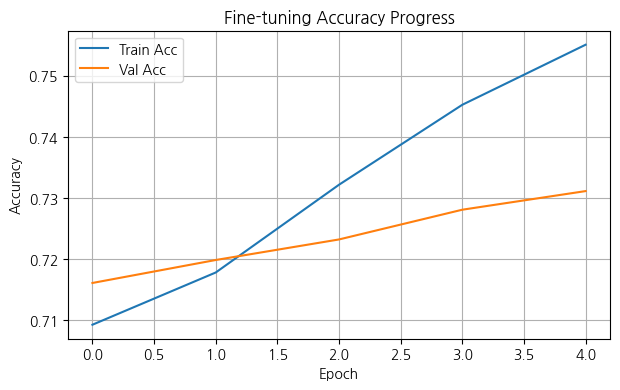

In [ ]:

# ===============================================
# 7. 성능 비교 출력
# ===============================================
print("\n======================")
print("ResNet50 성능 비교표")
print("======================")
print(f"사전 학습 모델 (학습 전) 정확도: {pretrained_eval[1]*100:.2f}%")
print(f"Fine-tuning 후 정확도: {fine_tuned_eval[1]*100:.2f}%")

# ===============================================
# 8. 시각화
# ===============================================
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuning Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

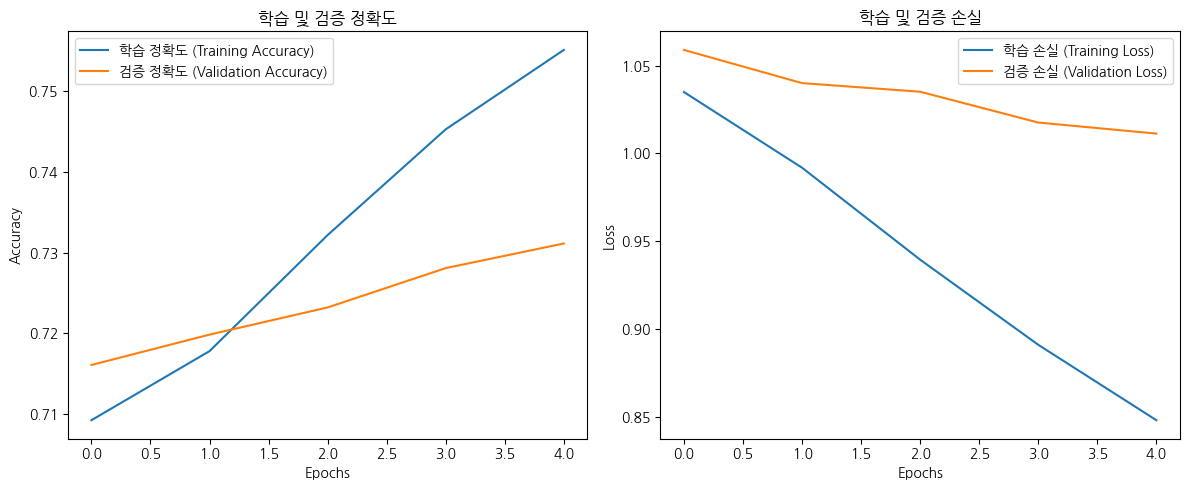

In [ ]:
import matplotlib.pyplot as plt

# (한글 폰트 설정이 필요하면 이전 코드의 폰트 설치 셀 실행)
# plt.rc('font', family='NanumBarunGothic')

# 1. 학습/검증 정확도(Accuracy) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(history.history['accuracy'], label='학습 정확도 (Training Accuracy)')
plt.plot(history.history['val_accuracy'], label='검증 정확도 (Validation Accuracy)')
plt.title('학습 및 검증 정확도')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2. 학습/검증 손실(Loss) 그래프
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(history.history['loss'], label='학습 손실 (Training Loss)')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)')
plt.title('학습 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # 그래프 간격 조절
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


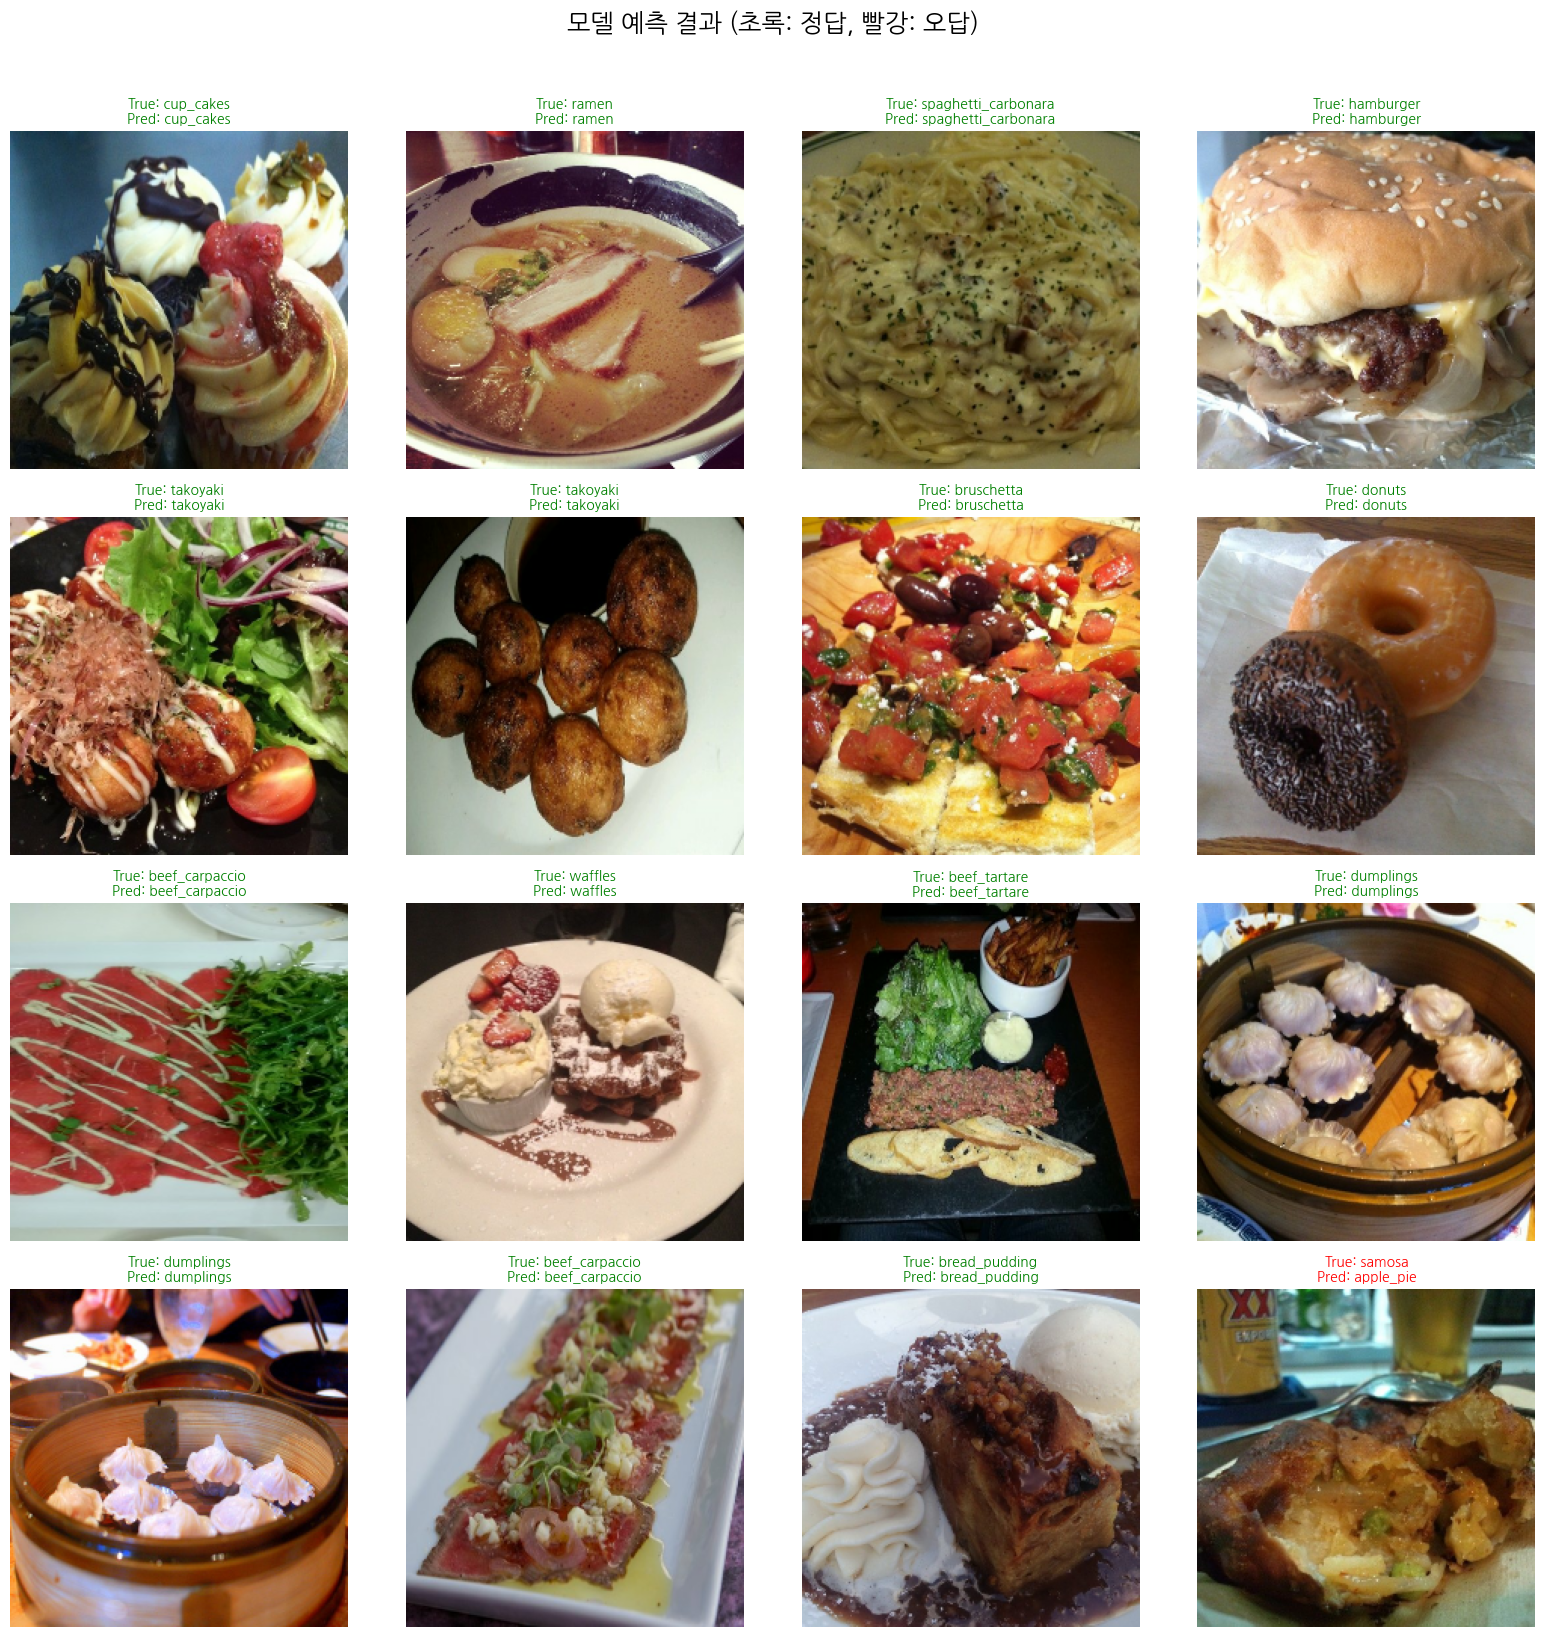

In [ ]:
# 1. 시각화를 위한 테스트 데이터 로더 (ResNet 정규화 X, [0, 1] 스케일링 O)
def preprocess_vis_test(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # [0, 1] 스케일링
    return image, label

vis_test_loader = ds_test.map(preprocess_vis_test).batch(BATCH_SIZE).take(1)

# 2. 1개 배치 가져오기
for vis_images, vis_labels in vis_test_loader:

    # 3. 예측 수행
    #    [0, 1] 범위의 이미지를 [0, 255]로 되돌린 후, ResNet 정규화 적용
    images_for_pred = tf.keras.applications.resnet.preprocess_input(vis_images * 255.0)
    predictions = model.predict(images_for_pred)

    # 가장 확률 높은 클래스 인덱스 추출
    pred_labels = np.argmax(predictions, axis=1)

    # 4. 시각화
    plt.figure(figsize=(16, 16))
    plt.suptitle("모델 예측 결과 (초록: 정답, 빨강: 오답)", fontsize=18, y=1.02)

    for i in range(min(16, len(vis_images))): # 최대 16개 이미지
        plt.subplot(4, 4, i + 1)

        # [0, 1] 범위의 이미지 표시
        plt.imshow(vis_images[i])

        true_label_name = class_names[vis_labels[i]]
        pred_label_name = class_names[pred_labels[i]]

        # 정답/오답에 따라 색상 변경
        if pred_labels[i] == vis_labels[i]:
            color = 'green' # 정답
        else:
            color = 'red'   # 오답

        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}",
                  color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break # 1개 배치만 확인

11/13일 가중치 수정


In [ ]:
# ===============================================
# 6. Fine-tuning (상위 block 일부 학습)
# ===============================================
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n▶ Fine-tuning 시작...")
history = model.fit(train_loader,
                    validation_data=test_loader,
                    epochs=15,
                    callbacks=callbacks_list)

fine_tuned_eval = model.evaluate(test_loader, verbose=1)


▶ Fine-tuning 시작...
Epoch 1/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1540 - loss: 3.9737
Epoch 1: val_loss improved from inf to 1.63576, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 242s 91ms/step - accuracy: 0.1541 - loss: 3.9731 - val_accuracy: 0.6067 - val_loss: 1.6358
Epoch 2/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5243 - loss: 1.9893
Epoch 2: val_loss improved from 1.63576 to 1.16481, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 58ms/step - accuracy: 0.5244 - loss: 1.9892 - val_accuracy: 0.7040 - val_loss: 1.1648
Epoch 3/15
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6232 - loss: 1.5219
Epoch 3: val_loss improved from 1.16481 to 1.00529, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 58ms/step - accuracy: 0.6232 - loss: 1.5218 - val_accuracy: 0.7415 - val_loss: 1.0053
Epoch 4/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6813 - loss: 1.2624
Epoch 4: val_loss improved from 1.00529 to 0.92020, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 70s 58ms/step - accuracy: 0.6813 - loss: 1.2624 - val_accuracy: 0.7594 - val_loss: 0.9202
Epoch 5/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7188 - loss: 1.0925
Epoch 5: val_loss improved from 0.92020 to 0.87006, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 58ms/step - accuracy: 0.7188 - loss: 1.0924 - val_accuracy: 0.7723 - val_loss: 0.8701
Epoch 6/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7537 - loss: 0.9513
Epoch 6: val_loss improved from 0.87006 to 0.84995, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 70s 58ms/step - accuracy: 0.7537 - loss: 0.9513 - val_accuracy: 0.7773 - val_loss: 0.8499
Epoch 7/15
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7809 - loss: 0.8352
Epoch 7: val_loss improved from 0.84995 to 0.82822, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 70s 58ms/step - accuracy: 0.7809 - loss: 0.8351 - val_accuracy: 0.7829 - val_loss: 0.8282
Epoch 8/15
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8069 - loss: 0.7350
Epoch 8: val_loss did not improve from 0.82822
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 57ms/step - accuracy: 0.8069 - loss: 0.7349 - val_accuracy: 0.7832 - val_loss: 0.8326
Epoch 9/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8285 - loss: 0.6484
Epoch 9: val_loss improved from 0.82822 to 0.82288, saving model to best_model.h5


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 70s 58ms/step - accuracy: 0.8285 - loss: 0.6484 - val_accuracy: 0.7874 - val_loss: 0.8229
Epoch 10/15
1183/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8434 - loss: 0.5780
Epoch 10: val_loss did not improve from 0.82288
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 57ms/step - accuracy: 0.8434 - loss: 0.5780 - val_accuracy: 0.7872 - val_loss: 0.8367
Epoch 11/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8633 - loss: 0.4997
Epoch 11: val_loss did not improve from 0.82288
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 57ms/step - accuracy: 0.8633 - loss: 0.4997 - val_accuracy: 0.7869 - val_loss: 0.8411
Epoch 12/15
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8768 - loss: 0.4480
Epoch 12: val_loss did not improve from 0.82288
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 69s 57ms/step - accuracy: 0.8768 - loss: 0.4479 - val_accuracy: 0.7881 - val_loss: 0.8575
Epoch 12: early stopping
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7893 - loss: 0.8570


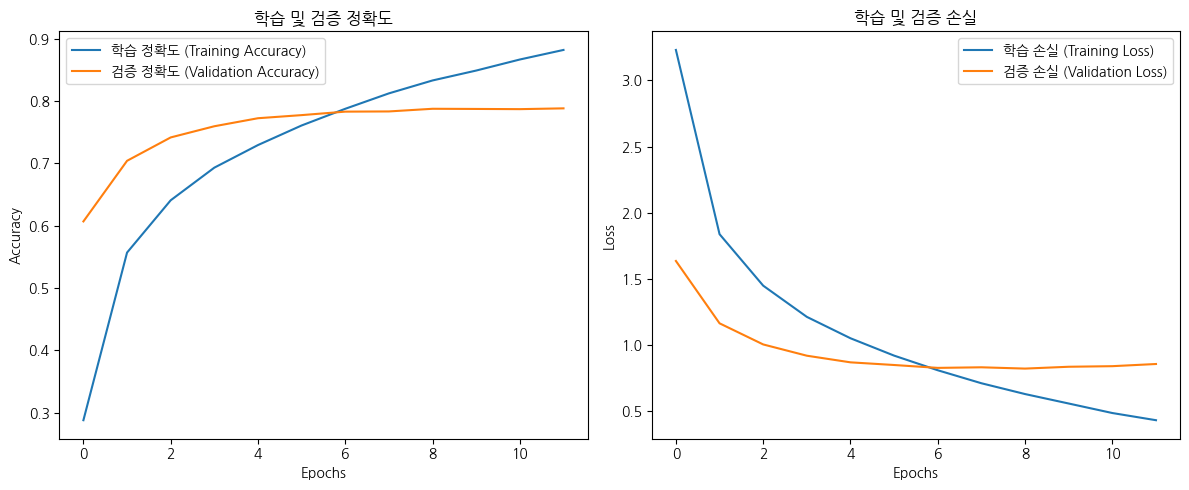

In [ ]:
import matplotlib.pyplot as plt

# (한글 폰트 설정이 필요하면 이전 코드의 폰트 설치 셀 실행)
# plt.rc('font', family='NanumBarunGothic')

# 1. 학습/검증 정확도(Accuracy) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(history.history['accuracy'], label='학습 정확도 (Training Accuracy)')
plt.plot(history.history['val_accuracy'], label='검증 정확도 (Validation Accuracy)')
plt.title('학습 및 검증 정확도')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2. 학습/검증 손실(Loss) 그래프
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(history.history['loss'], label='학습 손실 (Training Loss)')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)')
plt.title('학습 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # 그래프 간격 조절
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7893 - loss: 0.8570

ResNet50 성능 비교표
Fine-tuning 후 정확도: 78.81%


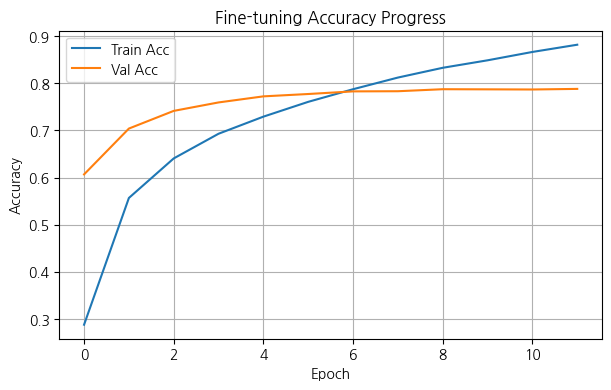

In [ ]:
fine_tuned_eval = model.evaluate(test_loader, verbose=1)

# ===============================================
# 7. 성능 비교 출력
# ===============================================
print("\n======================")
print("ResNet50 성능 비교표")
print("======================")

print(f"Fine-tuning 후 정확도: {fine_tuned_eval[1]*100:.2f}%")

# ===============================================
# 8. 시각화
# ===============================================
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuning Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Transfer Learning -> 파인튜닝

790/790 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5830 - loss: 1.6749

성능 비교표
사전 학습 모델 (학습 전) 정확도: 0.91%
Transfer Learning 후 정확도: 58.23%


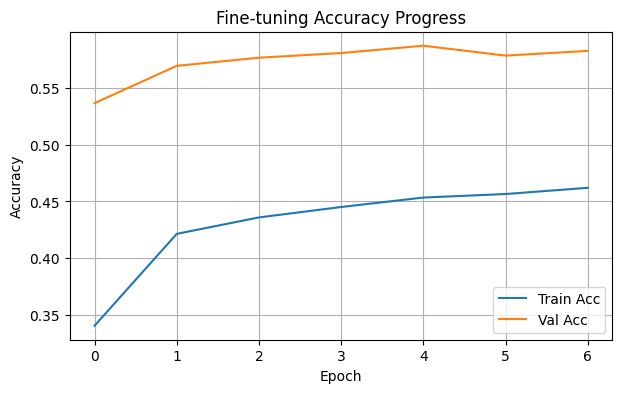

In [ ]:
t_tuned_eval = model.evaluate(test_loader, verbose=1)
# ===============================================
# 7. 성능 비교 출력
# ===============================================
print("\n======================")
print("성능 비교표")
print("======================")
print(f"사전 학습 모델 (학습 전) 정확도: {pretrained_eval[1]*100:.2f}%")
print(f"Transfer Learning 후 정확도: {t_tuned_eval[1]*100:.2f}%")

# ===============================================
# 8. 시각화
# ===============================================
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuning Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===============================================
# 6. Fine-tuning (상위 block 일부 학습)
# ===============================================
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n▶ Fine-tuning 시작...")
history = model.fit(train_loader,
                    validation_data=test_loader,
                    epochs=10,
                    callbacks=callbacks_list)

fine_tuned_eval = model.evaluate(test_loader, verbose=1)


▶ Fine-tuning 시작...
Epoch 1/10


KeyboardInterrupt: 

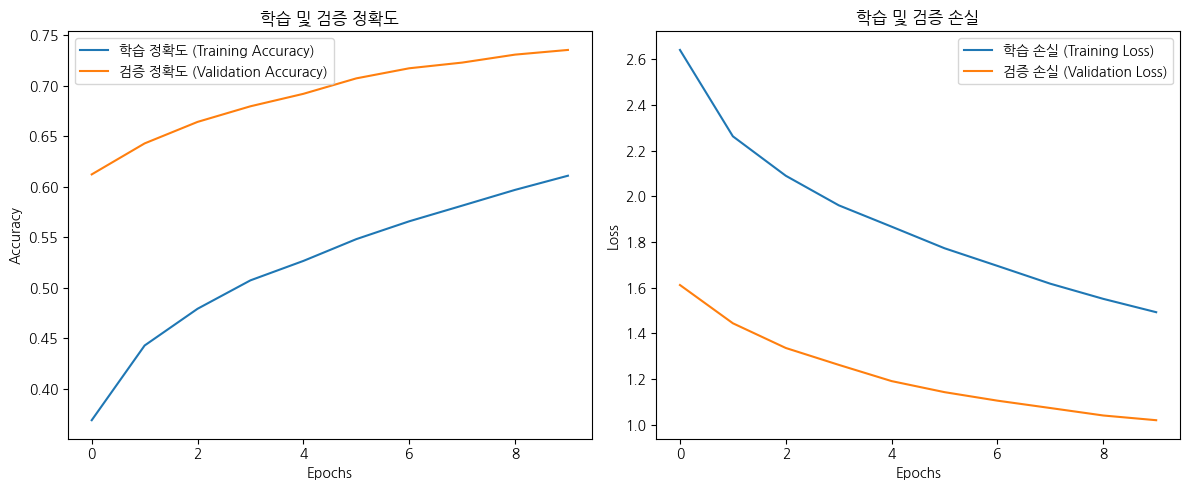

In [ ]:
import matplotlib.pyplot as plt

# (한글 폰트 설정이 필요하면 이전 코드의 폰트 설치 셀 실행)
# plt.rc('font', family='NanumBarunGothic')

# 1. 학습/검증 정확도(Accuracy) 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
plt.plot(history.history['accuracy'], label='학습 정확도 (Training Accuracy)')
plt.plot(history.history['val_accuracy'], label='검증 정확도 (Validation Accuracy)')
plt.title('학습 및 검증 정확도')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2. 학습/검증 손실(Loss) 그래프
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
plt.plot(history.history['loss'], label='학습 손실 (Training Loss)')
plt.plot(history.history['val_loss'], label='검증 손실 (Validation Loss)')
plt.title('학습 및 검증 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() # 그래프 간격 조절
plt.show()